In [1]:
import polars as pl
import unicodedata
import numpy
import seaborn as sns
import matplotlib.pyplot as plt

# Define the input CSV file and create a DataFrame
csv = 'input.csv'
df_csv = pl.read_csv(csv)

# Get the shape of dataframe
print(df_csv.shape)

(1433, 63)


In [2]:
# Unicode normalization to prevent major difficulties with any weird strings
string_df = df_csv.select(pl.col(pl.String))

df_normalized = df_csv.with_columns(
    df_csv.select(pl.col(pl.String).map_elements(lambda x : unicodedata.normalize("NFD" , str(x)) , return_dtype=pl.String))
)

df = df_normalized.with_columns(
    df_normalized.select(pl.col(pl.String).map_elements(lambda x : unicodedata.normalize("NFD" , str(x)) , return_dtype=pl.String))
)

In [3]:
# Here we rename the columns
# Create a list of all column names to preserve the originals for later
col_names = df.columns

# Dictionary to rename columns
new_names = { "Are you self-employed?" : "self-employed_indic" ,
             "How many employees does your company or organization have?" : "comp_size" ,
             "Is your employer primarily a tech company/organization?" : "tech_comp_indic" ,
             "Is your primary role within your company related to tech/IT?" : "tech_role_indic",
             "Does your employer provide mental health benefits as part of healthcare coverage?" : "availability_of_benefits" ,
             "Do you know the options for mental health care available under your employer-provided coverage?" : "awareness_of_benefits" , 
             "Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?" : "mh_discussion_indic" ,
             "Does your employer offer resources to learn more about mental health concerns and options for seeking help?" : "mh_resources_availability_indic" ,
             "Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?" : "anonym_use_benefit_indic" ,
             "If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:" : "sick_leave_difficulty" ,
             "Do you think that discussing a mental health disorder with your employer would have negative consequences?" : "neg_consequences_discussing_mh" ,
             "Do you think that discussing a physical health issue with your employer would have negative consequences?" : "neg_consequences_discussing_ph" ,
             "Would you feel comfortable discussing a mental health disorder with your coworkers?" : "comf_discussing_mh_with_coworker_indic" ,
             "Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?" : "comf_discussing_mnh_with_supervisor_indic" ,
             "Do you feel that your employer takes mental health as seriously as physical health?" : "employer_importance_mh_vs_ph" ,
             "Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?" : "known_neg_consequences_of_mh" ,
             "Do you have medical coverage (private insurance or state-provided) which includes treatment of \xa0mental health issues?" : "med_coverage_mh_indic" ,
             "Do you know local or online resources to seek help for a mental health disorder?" : "known_mh_sources" ,
             "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?" : "mention_mh_to_clients" ,
             "If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?" : "neg_impact_of_reveal_to_client_of_mh" ,
             "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?" : "mention_mh_to_employees" ,
             "If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?" : "neg_impact_of_reveal_to_employee_of_mh" ,
             "Do you believe your productivity is ever affected by a mental health issue?" : "productivity_effect_of_mh" ,
             "If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?" : "time_effect_of_mh" ,
             "Do you have previous employers?" : "prev_employers" ,
             "Have your previous employers provided mental health benefits?" : "availability_of_benefits_prev_employer" , 
             "Were you aware of the options for mental health care provided by your previous employers?" : "awareness_of_benefits_prev_employer" ,
             "Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?" : "mh_discussion_indic_prev_employer" ,
             "Did your previous employers provide resources to learn more about mental health issues and how to seek help?" : "mh_resources_availability_indic_prev_employer" ,
             "Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?" : "anonym_use_benefit_indic_prev_employer" ,
             "Do you think that discussing a mental health disorder with previous employers would have negative consequences?" : "neg_consequences_discussing_mh_prev_employer" , 
             "Do you think that discussing a physical health issue with previous employers would have negative consequences?" : "neg_consequences_discussing_ph_prev_employer" ,
             "Would you have been willing to discuss a mental health issue with your previous co-workers?" : "comf_discussing_mh_with_coworker_prev_employer" ,
             "Would you have been willing to discuss a mental health issue with your direct supervisor(s)?" : "comf_discussing_mnh_with_supervisor_prev_employer" ,
             "Did you feel that your previous employers took mental health as seriously as physical health?" : "employer_importance_mh_vs_ph_prev_employer" ,
             "Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?" : "known_neg_consequences_of_mh_prev_employer" ,
             "Would you be willing to bring up a physical health issue with a potential employer in an interview?" : "willing_discuss_ph_in_hiring_interview" ,
             "Why or why not?" : "why_why_not_1" ,
             "Would you bring up a mental health issue with a potential employer in an interview?" : "willing_discuss_mh_in_hiring_interview" ,
             "Why or why not?2" : "why_why_not_2" ,
             "Do you feel that being identified as a person with a mental health issue would hurt your career?" : "percevied_neg_impact_carreer_of_mh" ,
             "Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?" : "perceived_neg_impact_coworker_opiniton_of_mh" ,
             "How willing would you be to share with friends and family that you have a mental illness?" : "willingness_to_share_with_friend_family" ,
             "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?" : "neg_response_to_mh" ,
             "Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?" : "willingness_to_share_mh_after_observation" ,
             "Do you have a family history of mental illness?" : "mh_family_hist" ,
             "Have you had a mental health disorder in the past?" : "previous_mh" ,
             "Do you currently have a mental health disorder?" : "current_mh" ,
             "If yes, what condition(s) have you been diagnosed with?" :  "diagnosis_name_condition" ,
             "If maybe, what condition(s) do you believe you have?" : "believed_name_condiiton" ,
             "Have you been diagnosed with a mental health condition by a medical professional?" : "diagnosis_professional" ,
             "If so, what condition(s) were you diagnosed with?" : "diagnosis_name_professional_condition" ,
             "Have you ever sought treatment for a mental health issue from a mental health professional?" : "used_therapy" ,
             "If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?" : "interference_mh_treated_with_work" ,
             "If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?" : "interference_mh_untreated_with_work" ,
             "What is your age?" : "age" ,
             "What is your gender?" : "gender" ,
             "What country do you live in?" : "country_residency" ,
             "What US state or territory do you live in?" : "usa_state_residency" ,
             "What country do you work in?" : "country_work" ,
             "What US state or territory do you work in?" : "usa_state_work" ,
             "Which of the following best describes your work position?" : "job_title" ,
             "Do you work remotely?" : "remote" ,
            }

# Rename the keys in the dictionary with the names of the original DataFrame. This has to be done because I copied the titles from excel which was stupid
new_names = dict((col_names[list(new_names.keys()).index(key)], value) for key, value in new_names.items())
df = df.rename(new_names).with_row_index("index")

[Text(0, 0, '43'), Text(0, 0, '21'), Text(0, 0, '12')]

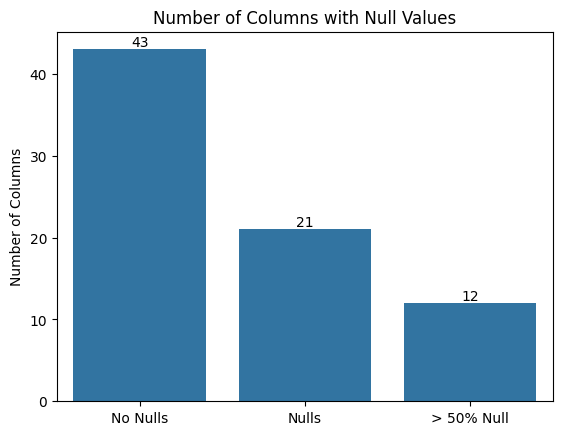

In [4]:
# Count columns with null values and those without
null_counts = df.null_count()

# Transpose the dataframe to write the amount of null values entriewise
null_counts_trans = null_counts.transpose(include_header= True)
# Get the number of columns with null values and without
true_null_counts = null_counts_trans.filter(pl.col("column_0") == 0).shape[0]
non_null_counts = null_counts_trans.filter(pl.col("column_0") != 0).shape[0]

# Calculate the percentage of NULL values per column and get the number
null_counts_perc = null_counts_trans.with_columns((pl.col("column_0") / 1433 * 100).cast(pl.Int32).alias("null_perc") )
num_null_counts_exc_50_perc = null_counts_perc.filter(pl.col("null_perc") >= 50).shape[0]

# Create a dictionary with the relevant information
nulls_dict = {"No Nulls" : non_null_counts , "Nulls" : true_null_counts ,  "> 50% Null" : num_null_counts_exc_50_perc}
# Plot the amount of columns with null values
ax = sns.barplot(data=nulls_dict)
ax.set(xlabel='' , ylabel='Number of Columns')
ax.set_title("Number of Columns with Null Values")
ax.bar_label(ax.containers[0], fontsize=10)

In [30]:
# Drop all columns that are meant for self-employed and have more than 50% Null values



# Drop all columns with more than 50% Null values
drop_col_list = pl.Series(null_counts_perc.filter(pl.col("null_perc")>50).select(pl.col("column"))).to_list()


'med_coverage_mh_indic'

In [5]:
# Get insights into Statistics. DF too large for useful information
df.describe()

# First look at a couple of entries
df.glimpse(max_items_per_column=10)
# Insights include: Some Categoricals are 0,1 even though it oculd be yes or no, some questions are for self-employed which can be dropped
# Column names are hard to work with and need to be renamed

Rows: 1433
Columns: 64
$ index                                             <u32> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
$ self-employed_indic                               <i64> 0, 0, 0, 1, 0, 0, 0, 0, 0, 1
$ comp_size                                         <str> '26-100', '6-25', '6-25', None, '6-25', 'More than 1000', '26-100', 'More than 1000', '26-100', None
$ tech_comp_indic                                   <i64> 1, 1, 1, None, 0, 1, 1, 1, 0, None
$ tech_role_indic                                   <i64> None, None, None, None, 1, None, None, None, 1, None
$ availability_of_benefits                          <str> 'Not eligible for coverage / N/A', 'No', 'No', None, 'Yes', 'Yes', "I don't know", 'Yes', "I don't know", None
$ awareness_of_benefits                             <str> 'N/A', 'Yes', 'N/A', None, 'Yes', 'I am not sure', 'No', 'Yes', 'No', None
$ mh_discussion_indic                               <str> 'No', 'Yes', 'No', None, 'No', 'No', 'No', 'No', 'No', None
$ mh_resources_avail

In [6]:
# We are only interested in the columns with less than 50% NaN values. Drop the rest

# We are only interested in the columns that are meant for employees. Drop the rest

# We are only interested in entries from employees. Drop the rest (Self-employed etc.)
# PS: maybe build in a little pie chart or such to have a look at diagnoesed, vs perceived mental health of employees vs. self-employed